In [10]:
from sklearn.datasets import load_digits
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.datasets import fetch_openml

In [11]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.0,1.0])
    plt.xlim([xleft, xright])
    #plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [12]:
# Load the digits dataset
X, y = fetch_openml('mnist_784', version=1, cache=True, return_X_y=True)
X, y = resample(X, y, n_samples=400)
#X = preprocessing.normalize(X, axis=1)
n_features = X.shape[1]
X_train, X_test = np.split(X, [200])
y_train, y_test = np.split(y, [200])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

In [13]:
X_test.shape

(200, 784)

In [14]:
@time_func
def RANDOM_SELECTION(CVal = 1, kernel='poly', w1 = [0.85, 0.15], ranking=None):
    data.kernel = 'linear'
    data.kernel_matrix = 'linear'
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*6)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

In [15]:
RANDOM_SELECTION()

__main__.RANDOM_SELECTION - 00:00:03.071215700


TypeError: '(slice(None, None, None), [220])' is an invalid key

In [7]:
@time_func
def SVM_RFE_VANILLA(step, C = 1, w1 = [0.85, 0.15]):
    data.kernel = 'linear'
    data.kernel_matrix = 'linear'
    data.C = C
    data.degree = 1
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_vanilla, index)

    #scores = list(map(data.svm_rfe_multi, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    #points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    points = {}
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

In [8]:
@time_func
def SVM_RFE_MULTI(step, C = 1, w1 = [0.85, 0.15]):
    data.kernel = 'linear'
    data.kernel_matrix = 'linear'
    data.C = C
    data.degree = 1
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_multi, index)

    #scores = list(map(data.svm_rfe_multi, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    #points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    points = {}
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time

In [9]:
SVM_RFE_VANILLA(20)

__main__.SVM_RFE_VANILLA - 00:00:03.225508600


KeyError: "None of [Int64Index([ 0,  2,  3,  5,  6,  8,  9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21,\n            22, 23, 24, 26, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,\n            43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60,\n            61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78,\n            79, 80, 82, 83, 84, 85, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97,\n            98],\n           dtype='int64')] are in the [index]"

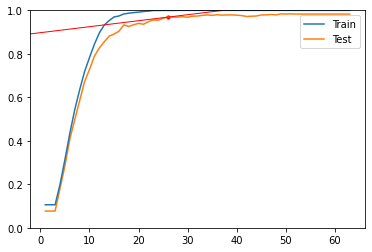

AT (26, 0.9690028281577577, 0.08728509606590593) WITH 0 ITERATIONS IN 1.0162015983036585 SECONDS : 0.0034827171528386503
__main__.SVM_RFE_MULTI - 00:00:05.647502100


((26, 0.9690028281577577, 0.08728509606590593), 1.0162015983036585)

In [60]:
SVM_RFE_MULTI(20)